In [1]:
# import libs and config stuff
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
#%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

!pip install transformers
from transformers import ViTModel

## Torchvision
import torchvision
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torchvision import transforms


# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint



import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install -U tensorflow-addons
import tensorflow_addons as tfa


<ipython-input-1-e56fe135fc6e>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


<Figure size 640x480 with 0 Axes>

In [2]:
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/content/drive/MyDrive/USP/TCC/experiments/saved_models/ViT/mark1"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)



# LOAD DATASET
img_size = 72
train_data_transform = transforms.Compose([
        transforms.Resize((img_size, img_size,)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((img_size,img_size),scale=(0.8,1.0),ratio=(0.9,1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
    ])

test_data_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
    ])

train_flowers_set = datasets.ImageFolder(root='/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes/train',
                                           transform=train_data_transform)

val_flowers_set = datasets.ImageFolder(root='/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes/val',
                                           transform=test_data_transform)

test_flowers_set = datasets.ImageFolder(root='/content/drive/MyDrive/USP/TCC/experiments/dataset_flowers_350_images_7_classes/test',
                                           transform=test_data_transform)


train_loader = torch.utils.data.DataLoader(train_flowers_set,
                                             batch_size=280, shuffle=True,
                                             num_workers=1)

val_loader = torch.utils.data.DataLoader(val_flowers_set,
                                             batch_size=35, shuffle=False,
                                             num_workers=1)

test_loader = torch.utils.data.DataLoader(test_flowers_set,
                                             batch_size=35, shuffle=False,
                                             num_workers=1)

# NUM_IMAGES = 10
# images = torch.stack([val_flowers_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
# img_grid = torchvision.utils.make_grid(images, nrow=5, normalize=True, pad_value=0.9)
# img_grid = img_grid.permute(1, 2, 0)

# plt.figure(figsize=(12,12))
# plt.title("Image examples of flowers dataset")
# plt.imshow(img_grid)
# plt.axis('off')
# plt.show()
# plt.close()


INFO:lightning_fabric.utilities.seed:Global seed set to 42


Device: cuda:0


In [3]:
for data in test_loader:
  (x_test, y_test) = data
for data in train_loader:
  (x_train, y_train) = data

print(f"x_train shape: {x_test.shape} - y_train shape: {y_test.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

y_test = y_test.reshape((35,1))
y_test = y_test.numpy()
x_test = np.moveaxis(x_test.numpy(), 1, 3)
x_test = np.moveaxis(x_test, 1, 2)

y_train = y_train.reshape((280,1))
y_train = y_train.numpy()
x_train = np.moveaxis(x_train.numpy(), 1, 3)
x_train = np.moveaxis(x_train, 1, 2)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: torch.Size([35, 3, 72, 72]) - y_train shape: torch.Size([35])
x_test shape: torch.Size([35, 3, 72, 72]) - y_test shape: torch.Size([35])
x_train shape: (280, 72, 72, 3) - y_train shape: (280, 1)
x_test shape: (35, 72, 72, 3) - y_test shape: (35, 1)


In [13]:
num_classes = 7
input_shape = (72, 72, 3)

# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

# print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
# print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")



In [14]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [15]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


In [16]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [17]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


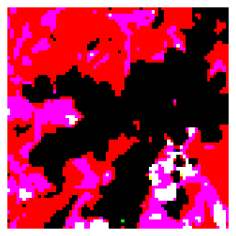

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")


In [19]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [20]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [23]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/100
1/1 [==============================] - 15s 15s/step - loss: 4.3576 - accuracy: 0.1508 - top-5-accuracy: 0.7262 - val_loss: 2.1344 - val_accuracy: 0.5357 - val_top-5-accuracy: 0.9286
Epoch 2/100
1/1 [==============================] - 0s 481ms/step - loss: 4.8335 - accuracy: 0.3929 - top-5-accuracy: 0.8373 - val_loss: 5.1836 - val_accuracy: 0.3929 - val_top-5-accuracy: 0.9286
Epoch 3/100
1/1 [==============================] - 0s 391ms/step - loss: 3.3843 - accuracy: 0.5079 - top-5-accuracy: 0.9484 - val_loss: 3.5970 - val_accuracy: 0.3214 - val_top-5-accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 4.5848 - accuracy: 0.5000 - top-5-accuracy: 0.9762 - val_loss: 1.7148 - val_accuracy: 0.5714 - val_top-5-accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 3.0188 - accuracy: 0.5556 - top-5-accuracy: 0.9921 - val_loss: 2.0597 - val_accuracy: 0.6429 - val_top-5-accuracy: 1.0000
Epoch 6/100
1/1 [===============

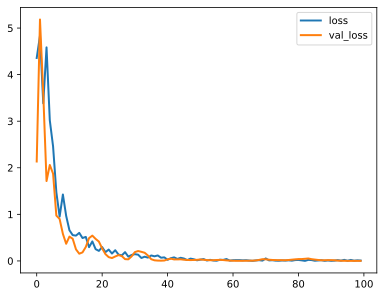

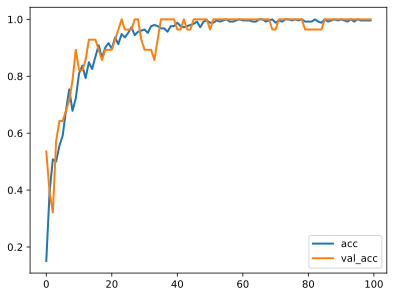

In [24]:
#Some visualizations
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()